In [7]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
X_train.shape, X_val.shape, X_test.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((55000, 784), (5000, 784), (10000, 784))

In [8]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [9]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        self.y_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
#         dX = dout @ W.T # vanilla Backprop
        dX = dout @ W_fixed.T # fba backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
#         y, nl_cache = l.sigmoid_forward(X=y) # non-linearity/ activation
#         y -= l.sigmoid(0.0) # zero-centered/ mean
#         y *= 2.0 # uni-var/ std
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
#             y, nl_cache = l.sigmoid_forward(X=y) # non-linearity/ activation
#             y -= l.sigmoid(0.0) # zero-centered/ mean
#             y *= 2.0 # uni-var/ std
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches, y):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
        dy_prev = self.dy_prev.copy() # for temporal differencing
        self.dy_prev = dy.copy() # next iteration/ epoch
#         y_prev = self.y_prev.copy() # for temporal differencing
#         self.y_prev = y.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward is included in dcross_entropy.
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
#         dy =  dy @ self.W_fixed[2].T # done
        dy_prev =  dy_prev @ self.W_fixed[2].T
#         y =  y @ self.W_fixed[2].T # done
#         y_prev =  y_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
#             dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
            dy *= dy - dy_prev # temporal diff instead of differentiable function
#             dy *= y - y_prev # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
#             dy =  dy @ self.W_fixed[2].T # done
            dy_prev =  dy_prev @ self.W_fixed[1][layer].T
#             y =  y @ self.W_fixed[1][layer].T # done
#             y_prev =  y_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
#         dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
#         dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
        dy *= dy - dy_prev # temporal diff instead of differentiable function
#         dy *= y - y_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            _, grads = self.train_backward(dy, caches, y_prob)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
#             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
#             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [4]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-2.2534, acc-0.1600, valid loss-2.2816, acc-0.1628, test loss-2.2830, acc-0.1658
Iter-20, train loss-2.2842, acc-0.1800, valid loss-2.2815, acc-0.1634, test loss-2.2829, acc-0.1660
Iter-30, train loss-2.2901, acc-0.1200, valid loss-2.2813, acc-0.1632, test loss-2.2827, acc-0.1664
Iter-40, train loss-2.3006, acc-0.1200, valid loss-2.2812, acc-0.1636, test loss-2.2826, acc-0.1665
Iter-50, train loss-2.2786, acc-0.1600, valid loss-2.2811, acc-0.1638, test loss-2.2825, acc-0.1670
Iter-60, train loss-2.2676, acc-0.2600, valid loss-2.2809, acc-0.1638, test loss-2.2824, acc-0.1669
Iter-70, train loss-2.2843, acc-0.1000, valid loss-2.2808, acc-0.1640, test loss-2.2823, acc-0.1672
Iter-80, train loss-2.2771, acc-0.2200, valid loss-2.2807, acc-0.1640, test loss-2.2821, acc-0.1675
Iter-90, train loss-2.2723, acc-0.1800, valid loss-2.2806, acc-0.1650, test loss-2.2820, acc-0.1679
Iter-100, train loss-2.2542, acc-0.2800, valid loss-2.2805, acc-0.1658, test loss-2.2819, acc-0.1675

Iter-830, train loss-2.2750, acc-0.1000, valid loss-2.2714, acc-0.1836, test loss-2.2730, acc-0.1846
Iter-840, train loss-2.2797, acc-0.1400, valid loss-2.2713, acc-0.1844, test loss-2.2728, acc-0.1850
Iter-850, train loss-2.2837, acc-0.1200, valid loss-2.2712, acc-0.1850, test loss-2.2727, acc-0.1859
Iter-860, train loss-2.2676, acc-0.2200, valid loss-2.2710, acc-0.1852, test loss-2.2726, acc-0.1858
Iter-870, train loss-2.2583, acc-0.2600, valid loss-2.2709, acc-0.1852, test loss-2.2724, acc-0.1859
Iter-880, train loss-2.2775, acc-0.1600, valid loss-2.2708, acc-0.1854, test loss-2.2723, acc-0.1863
Iter-890, train loss-2.2850, acc-0.1600, valid loss-2.2707, acc-0.1858, test loss-2.2722, acc-0.1862
Iter-900, train loss-2.2726, acc-0.1800, valid loss-2.2705, acc-0.1858, test loss-2.2721, acc-0.1861
Iter-910, train loss-2.2696, acc-0.1600, valid loss-2.2704, acc-0.1862, test loss-2.2720, acc-0.1868
Iter-920, train loss-2.2855, acc-0.2000, valid loss-2.2703, acc-0.1868, test loss-2.2718, a

Iter-1640, train loss-2.2567, acc-0.1800, valid loss-2.2616, acc-0.2014, test loss-2.2633, acc-0.2069
Iter-1650, train loss-2.2917, acc-0.1600, valid loss-2.2615, acc-0.2014, test loss-2.2632, acc-0.2072
Iter-1660, train loss-2.2694, acc-0.1200, valid loss-2.2614, acc-0.2018, test loss-2.2630, acc-0.2076
Iter-1670, train loss-2.2637, acc-0.2200, valid loss-2.2613, acc-0.2022, test loss-2.2629, acc-0.2078
Iter-1680, train loss-2.2577, acc-0.1800, valid loss-2.2611, acc-0.2022, test loss-2.2628, acc-0.2080
Iter-1690, train loss-2.2415, acc-0.2000, valid loss-2.2610, acc-0.2024, test loss-2.2627, acc-0.2083
Iter-1700, train loss-2.2650, acc-0.2400, valid loss-2.2609, acc-0.2026, test loss-2.2626, acc-0.2087
Iter-1710, train loss-2.2690, acc-0.2200, valid loss-2.2608, acc-0.2024, test loss-2.2624, acc-0.2090
Iter-1720, train loss-2.2641, acc-0.2200, valid loss-2.2607, acc-0.2028, test loss-2.2623, acc-0.2093
Iter-1730, train loss-2.2337, acc-0.4000, valid loss-2.2605, acc-0.2030, test loss

Iter-2450, train loss-2.2754, acc-0.2200, valid loss-2.2521, acc-0.2270, test loss-2.2538, acc-0.2288
Iter-2460, train loss-2.2667, acc-0.2000, valid loss-2.2520, acc-0.2272, test loss-2.2537, acc-0.2287
Iter-2470, train loss-2.2581, acc-0.1200, valid loss-2.2519, acc-0.2272, test loss-2.2536, acc-0.2289
Iter-2480, train loss-2.2641, acc-0.2400, valid loss-2.2518, acc-0.2272, test loss-2.2535, acc-0.2292
Iter-2490, train loss-2.2557, acc-0.2000, valid loss-2.2517, acc-0.2274, test loss-2.2534, acc-0.2291
Iter-2500, train loss-2.2560, acc-0.2400, valid loss-2.2516, acc-0.2280, test loss-2.2533, acc-0.2293
Iter-2510, train loss-2.2538, acc-0.2600, valid loss-2.2515, acc-0.2284, test loss-2.2532, acc-0.2295
Iter-2520, train loss-2.2455, acc-0.2000, valid loss-2.2513, acc-0.2284, test loss-2.2530, acc-0.2302
Iter-2530, train loss-2.2603, acc-0.2000, valid loss-2.2512, acc-0.2294, test loss-2.2529, acc-0.2308
Iter-2540, train loss-2.2469, acc-0.2400, valid loss-2.2511, acc-0.2296, test loss

Iter-3260, train loss-2.2313, acc-0.3200, valid loss-2.2428, acc-0.2474, test loss-2.2445, acc-0.2501
Iter-3270, train loss-2.2332, acc-0.2000, valid loss-2.2427, acc-0.2480, test loss-2.2444, acc-0.2504
Iter-3280, train loss-2.2411, acc-0.3000, valid loss-2.2426, acc-0.2482, test loss-2.2443, acc-0.2505
Iter-3290, train loss-2.2070, acc-0.3800, valid loss-2.2424, acc-0.2484, test loss-2.2442, acc-0.2507
Iter-3300, train loss-2.2273, acc-0.3400, valid loss-2.2423, acc-0.2494, test loss-2.2441, acc-0.2511
Iter-3310, train loss-2.2582, acc-0.2000, valid loss-2.2422, acc-0.2498, test loss-2.2440, acc-0.2514
Iter-3320, train loss-2.2588, acc-0.2400, valid loss-2.2421, acc-0.2496, test loss-2.2438, acc-0.2515
Iter-3330, train loss-2.2489, acc-0.2800, valid loss-2.2420, acc-0.2500, test loss-2.2437, acc-0.2515
Iter-3340, train loss-2.2448, acc-0.2200, valid loss-2.2419, acc-0.2500, test loss-2.2436, acc-0.2516
Iter-3350, train loss-2.2431, acc-0.1600, valid loss-2.2418, acc-0.2504, test loss

Iter-4070, train loss-2.2426, acc-0.2600, valid loss-2.2334, acc-0.2712, test loss-2.2353, acc-0.2730
Iter-4080, train loss-2.2336, acc-0.3000, valid loss-2.2333, acc-0.2710, test loss-2.2352, acc-0.2733
Iter-4090, train loss-2.2379, acc-0.2600, valid loss-2.2332, acc-0.2712, test loss-2.2351, acc-0.2734
Iter-4100, train loss-2.2562, acc-0.2000, valid loss-2.2331, acc-0.2712, test loss-2.2350, acc-0.2733
Iter-4110, train loss-2.2423, acc-0.2800, valid loss-2.2330, acc-0.2726, test loss-2.2348, acc-0.2737
Iter-4120, train loss-2.2418, acc-0.2200, valid loss-2.2329, acc-0.2732, test loss-2.2347, acc-0.2741
Iter-4130, train loss-2.2486, acc-0.3000, valid loss-2.2327, acc-0.2742, test loss-2.2346, acc-0.2736
Iter-4140, train loss-2.2315, acc-0.2200, valid loss-2.2326, acc-0.2744, test loss-2.2345, acc-0.2740
Iter-4150, train loss-2.2405, acc-0.2600, valid loss-2.2325, acc-0.2746, test loss-2.2344, acc-0.2743
Iter-4160, train loss-2.2386, acc-0.1800, valid loss-2.2324, acc-0.2750, test loss

Iter-4880, train loss-2.2350, acc-0.2200, valid loss-2.2243, acc-0.2926, test loss-2.2263, acc-0.2924
Iter-4890, train loss-2.2256, acc-0.2600, valid loss-2.2242, acc-0.2928, test loss-2.2262, acc-0.2923
Iter-4900, train loss-2.2388, acc-0.2600, valid loss-2.2241, acc-0.2928, test loss-2.2261, acc-0.2926
Iter-4910, train loss-2.2180, acc-0.3200, valid loss-2.2240, acc-0.2928, test loss-2.2259, acc-0.2926
Iter-4920, train loss-2.2136, acc-0.3200, valid loss-2.2239, acc-0.2938, test loss-2.2258, acc-0.2923
Iter-4930, train loss-2.2160, acc-0.3600, valid loss-2.2238, acc-0.2938, test loss-2.2257, acc-0.2930
Iter-4940, train loss-2.2048, acc-0.3600, valid loss-2.2237, acc-0.2936, test loss-2.2256, acc-0.2933
Iter-4950, train loss-2.2046, acc-0.2400, valid loss-2.2236, acc-0.2940, test loss-2.2255, acc-0.2934
Iter-4960, train loss-2.2259, acc-0.3200, valid loss-2.2234, acc-0.2940, test loss-2.2254, acc-0.2935
Iter-4970, train loss-2.2391, acc-0.2600, valid loss-2.2233, acc-0.2944, test loss

Iter-5690, train loss-2.2421, acc-0.2800, valid loss-2.2154, acc-0.3130, test loss-2.2174, acc-0.3098
Iter-5700, train loss-2.2136, acc-0.3000, valid loss-2.2152, acc-0.3132, test loss-2.2173, acc-0.3101
Iter-5710, train loss-2.1984, acc-0.4000, valid loss-2.2151, acc-0.3138, test loss-2.2172, acc-0.3108
Iter-5720, train loss-2.1886, acc-0.4200, valid loss-2.2150, acc-0.3138, test loss-2.2171, acc-0.3109
Iter-5730, train loss-2.2133, acc-0.2800, valid loss-2.2149, acc-0.3140, test loss-2.2170, acc-0.3110
Iter-5740, train loss-2.1949, acc-0.4600, valid loss-2.2148, acc-0.3142, test loss-2.2168, acc-0.3113
Iter-5750, train loss-2.2407, acc-0.2600, valid loss-2.2147, acc-0.3142, test loss-2.2167, acc-0.3113
Iter-5760, train loss-2.2116, acc-0.3600, valid loss-2.2146, acc-0.3142, test loss-2.2166, acc-0.3116
Iter-5770, train loss-2.1960, acc-0.4400, valid loss-2.2145, acc-0.3142, test loss-2.2165, acc-0.3113
Iter-5780, train loss-2.2332, acc-0.3000, valid loss-2.2144, acc-0.3144, test loss

Iter-6500, train loss-2.2188, acc-0.3200, valid loss-2.2065, acc-0.3240, test loss-2.2087, acc-0.3217
Iter-6510, train loss-2.2369, acc-0.2200, valid loss-2.2064, acc-0.3242, test loss-2.2086, acc-0.3223
Iter-6520, train loss-2.1823, acc-0.4200, valid loss-2.2063, acc-0.3244, test loss-2.2085, acc-0.3222
Iter-6530, train loss-2.2181, acc-0.2200, valid loss-2.2062, acc-0.3240, test loss-2.2084, acc-0.3226
Iter-6540, train loss-2.2174, acc-0.2600, valid loss-2.2061, acc-0.3246, test loss-2.2083, acc-0.3227
Iter-6550, train loss-2.2005, acc-0.2600, valid loss-2.2060, acc-0.3250, test loss-2.2082, acc-0.3227
Iter-6560, train loss-2.1873, acc-0.4200, valid loss-2.2059, acc-0.3254, test loss-2.2081, acc-0.3231
Iter-6570, train loss-2.2042, acc-0.4000, valid loss-2.2058, acc-0.3258, test loss-2.2079, acc-0.3231
Iter-6580, train loss-2.2031, acc-0.3600, valid loss-2.2057, acc-0.3260, test loss-2.2078, acc-0.3232
Iter-6590, train loss-2.1919, acc-0.3200, valid loss-2.2055, acc-0.3264, test loss

Iter-7310, train loss-2.2086, acc-0.3400, valid loss-2.1979, acc-0.3382, test loss-2.2001, acc-0.3321
Iter-7320, train loss-2.2084, acc-0.3200, valid loss-2.1978, acc-0.3384, test loss-2.2000, acc-0.3324
Iter-7330, train loss-2.2118, acc-0.3000, valid loss-2.1977, acc-0.3384, test loss-2.1999, acc-0.3325
Iter-7340, train loss-2.2099, acc-0.3000, valid loss-2.1976, acc-0.3388, test loss-2.1998, acc-0.3327
Iter-7350, train loss-2.1727, acc-0.3200, valid loss-2.1975, acc-0.3394, test loss-2.1997, acc-0.3329
Iter-7360, train loss-2.1839, acc-0.3400, valid loss-2.1974, acc-0.3398, test loss-2.1996, acc-0.3329
Iter-7370, train loss-2.1738, acc-0.4000, valid loss-2.1973, acc-0.3398, test loss-2.1995, acc-0.3330
Iter-7380, train loss-2.2189, acc-0.3200, valid loss-2.1972, acc-0.3394, test loss-2.1994, acc-0.3328
Iter-7390, train loss-2.1967, acc-0.4000, valid loss-2.1971, acc-0.3392, test loss-2.1993, acc-0.3325
Iter-7400, train loss-2.2161, acc-0.2800, valid loss-2.1970, acc-0.3392, test loss

Iter-8120, train loss-2.1805, acc-0.3600, valid loss-2.1894, acc-0.3470, test loss-2.1917, acc-0.3424
Iter-8130, train loss-2.2248, acc-0.2000, valid loss-2.1893, acc-0.3472, test loss-2.1916, acc-0.3427
Iter-8140, train loss-2.2098, acc-0.3000, valid loss-2.1892, acc-0.3476, test loss-2.1915, acc-0.3428
Iter-8150, train loss-2.1964, acc-0.3400, valid loss-2.1891, acc-0.3474, test loss-2.1914, acc-0.3428
Iter-8160, train loss-2.1760, acc-0.4400, valid loss-2.1890, acc-0.3474, test loss-2.1913, acc-0.3429
Iter-8170, train loss-2.1871, acc-0.2800, valid loss-2.1889, acc-0.3472, test loss-2.1912, acc-0.3436
Iter-8180, train loss-2.2285, acc-0.2400, valid loss-2.1888, acc-0.3472, test loss-2.1911, acc-0.3441
Iter-8190, train loss-2.1884, acc-0.3600, valid loss-2.1887, acc-0.3476, test loss-2.1910, acc-0.3442
Iter-8200, train loss-2.1739, acc-0.4800, valid loss-2.1886, acc-0.3480, test loss-2.1909, acc-0.3440
Iter-8210, train loss-2.2012, acc-0.2800, valid loss-2.1885, acc-0.3480, test loss

Iter-8930, train loss-2.1660, acc-0.3800, valid loss-2.1810, acc-0.3562, test loss-2.1835, acc-0.3508
Iter-8940, train loss-2.1949, acc-0.3200, valid loss-2.1809, acc-0.3562, test loss-2.1834, acc-0.3514
Iter-8950, train loss-2.1592, acc-0.4000, valid loss-2.1808, acc-0.3560, test loss-2.1833, acc-0.3516
Iter-8960, train loss-2.1832, acc-0.3600, valid loss-2.1807, acc-0.3558, test loss-2.1832, acc-0.3515
Iter-8970, train loss-2.2024, acc-0.1800, valid loss-2.1806, acc-0.3560, test loss-2.1831, acc-0.3515
Iter-8980, train loss-2.1863, acc-0.3400, valid loss-2.1805, acc-0.3560, test loss-2.1830, acc-0.3515
Iter-8990, train loss-2.1905, acc-0.3400, valid loss-2.1804, acc-0.3564, test loss-2.1829, acc-0.3515
Iter-9000, train loss-2.1668, acc-0.4800, valid loss-2.1803, acc-0.3560, test loss-2.1828, acc-0.3515
Iter-9010, train loss-2.1393, acc-0.4600, valid loss-2.1802, acc-0.3566, test loss-2.1827, acc-0.3516
Iter-9020, train loss-2.1938, acc-0.2600, valid loss-2.1801, acc-0.3564, test loss

Iter-9740, train loss-2.1523, acc-0.4200, valid loss-2.1727, acc-0.3622, test loss-2.1753, acc-0.3583
Iter-9750, train loss-2.1506, acc-0.3200, valid loss-2.1726, acc-0.3622, test loss-2.1752, acc-0.3585
Iter-9760, train loss-2.1959, acc-0.3600, valid loss-2.1725, acc-0.3622, test loss-2.1751, acc-0.3586
Iter-9770, train loss-2.1906, acc-0.1800, valid loss-2.1724, acc-0.3626, test loss-2.1750, acc-0.3587
Iter-9780, train loss-2.1577, acc-0.3600, valid loss-2.1723, acc-0.3628, test loss-2.1749, acc-0.3590
Iter-9790, train loss-2.1710, acc-0.3000, valid loss-2.1722, acc-0.3630, test loss-2.1748, acc-0.3593
Iter-9800, train loss-2.2061, acc-0.2600, valid loss-2.1721, acc-0.3624, test loss-2.1747, acc-0.3592
Iter-9810, train loss-2.1674, acc-0.4200, valid loss-2.1720, acc-0.3624, test loss-2.1746, acc-0.3593
Iter-9820, train loss-2.2036, acc-0.2400, valid loss-2.1719, acc-0.3622, test loss-2.1745, acc-0.3592
Iter-9830, train loss-2.1818, acc-0.3200, valid loss-2.1718, acc-0.3626, test loss

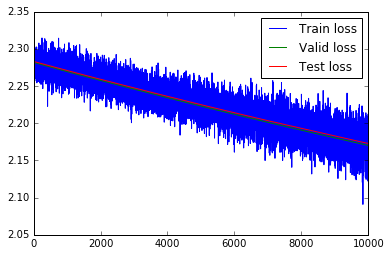

In [5]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

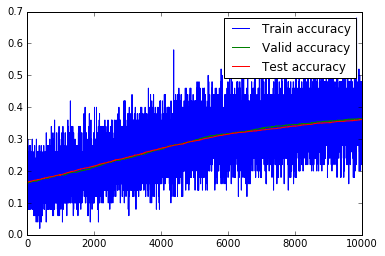

In [6]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()